# W207 Final Project: Stock Price Prediction on the Jane Street Dataset

## Team Members

John Andrus  
Fernando Roriz  
Kevin Fu  
Luis Chion  

## Introduction

In February 2021, Jane Street Group sponsored a featured competition on Kaggle where individuals could train machine learning models on real-world financial data and compete to achieve the highest return in a stock-trading simulation. The data consisted of approximately 1.5 million instances of time-series market data expressed over 130 anonmyous features, a return, and a binary buy/sell label. In this project, our team uses the Jane Street dataset to create our own models in an attempt to maximize the accuracy of our predictions and the hypothetical return of our trades.  

In this report, we explore an initial sampling of machine learning models on subsections of the training data, evaluate those models on runtime and accuracy, and select from among them the three models with the highest performance and the most support within the academic literature. We then take a deeper dive into these three choices - CNN, GMM, and LSTM - in order to refine their hyperparameters and maximize their utility in solving this problem.  

Finally, we will compare all of the models in a horse race. We will draw conclusions from the three final models we selected, evaluating whether both their accuracy and their utility scores would create a profitable training model and which, if any, have the potential to be delivered to a real-world trading scenario. We will then identify areas for improvement, areas for future work, and lessons learned.

## Import Relevant Libraries and Packages

The cell below houses a listing of all of the libraries and packages that are used in this report, separated by purpose.

In [3]:
# Import relevant libraries and packages

#Data Analysis
import numpy as np
import scipy
import pandas as pd

#Visualization
from matplotlib import pyplot as plt
import seaborn as sns

#Runtime Evaluation
import time

#Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

#Tools, Metrics, and Reports
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn import tree
from tabulate import tabulate

sns.set_style('whitegrid')
SEED = 2222
np.random.seed(SEED)

## Workflow


This Jupyter notebook was created in Google Colaboratory and trained on data stored in Google Drive. The cell below mounts our shared team Google Drive into the Colab workspace, giving us access to the dataset.

In [4]:
# Mount Google Drive to this location
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and Organize Preprocessed Dataset


Reference final_project_data_preprocessing.ipynb to see in-depth exploration of the data and preprocessing activities that were used to generate the train_jain.npz data file.

In [5]:
#Load the preprocessed dataset stored in .npz format
%%time 
train = np.load('drive/MyDrive/w207-6-spring2021-fintech/janestreet_dataset/train_jane.npz')
print(train.files)

['X_train', 'y_train', 'dates', 'weights', 'resps']
CPU times: user 2.24 ms, sys: 0 ns, total: 2.24 ms
Wall time: 15.3 ms


In the cells below, we separate the full dataset into separate Training, Dev, and Test datasets. Given that this is time series data, we did not use a Train-Test split. The data is in chronological order and we opted to preserve that order. We have also created a mini training dataset in order to speed up computation time in the earlier stages of our model exploration.

In [6]:
# Organize data into feature variables and labels
X_train = train['X_train']
y_train = train['y_train']
dates=train['dates']
weights=train['weights'] 
resps=train['resps']

In [7]:
# Set some variables to hold test, dev, and training data
test_data, test_labels, test_dates, test_weights, test_resps = X_train[80000:100000], y_train[80000:100000], dates[80000:100000], weights[80000:100000], resps[80000:100000]
dev_data, dev_labels, dev_dates, dev_weights, dev_resps = X_train[150000:200000], y_train[150000:200000], dates[150000:200000], weights[150000:200000], resps[150000:200000]
train_data, train_labels, train_dates, train_weights, train_resps = X_train[:70000], y_train[:70000], dates[:70000], weights[:70000], resps[:70000]
mini_train_data, mini_train_labels, mini_train_dates, mini_train_weights, mini_train_resps = X_train[:50000], y_train[:50000], dates[:50000], weights[:50000], resps[:50000]

# Previous iterations
#dev_data, dev_labels, dev_dates, dev_weights, dev_resps = X_train[50000:70000], y_train[50000:70000], dates[50000:70000], weights[50000:70000], resps[50000:70000]

In [8]:
#Display shapes of Train, Dev, and Test Data
print('Shape of Full Dataset Features:',X_train.shape)
print('Shape of Full Dataset Labels:',y_train.shape)
print('Shape of Training Data Features:',train_data.shape)
print('Shape of Training Data Labels:',train_labels.shape)
print('Shape of Test Data Features:',test_data.shape)
print('Shape of Test Data Labels:',test_labels.shape)
print('Shape of Dev Data Features:',dev_data.shape)
print('Shape of Dev Data Labels:',dev_labels.shape)
print('Shape of Mini Train Data Features:',mini_train_data.shape)
print('Shape of Mini Train Data Labels:',mini_train_labels.shape)


# Create empty dict to save accuracy and utilities
horse_race = {'model' : [], 'accuracy' : [], 'utility' : []}

Shape of Full Dataset Features: (1571415, 126)
Shape of Full Dataset Labels: (1571415, 1)
Shape of Training Data Features: (70000, 126)
Shape of Training Data Labels: (70000, 1)
Shape of Test Data Features: (20000, 126)
Shape of Test Data Labels: (20000, 1)
Shape of Dev Data Features: (50000, 126)
Shape of Dev Data Labels: (50000, 1)
Shape of Mini Train Data Features: (50000, 126)
Shape of Mini Train Data Labels: (50000, 1)


## Utility Function



This competition is evaluated on a utility score. Each row in the test set represents a trading opportunity for which you will be predicting an `action` value, 1 to make the trade and 0 to pass on it. Each trade j has an associated `weight` and `resp`, which represents a return.

For each `date` i, we define:

$$p_i = \sum_j(weight_{ij} * resp_{ij} * action_{ij}),$$
$$t = \frac{\sum p_i }{\sqrt{\sum p_i^2}} * \sqrt{\frac{250}{|i|}},$$

where $|i|$ is the number of unique dates in the test set. The utility is then defined as:

$$u = min(max(t,0), 6)  \sum p_i.$$

This section implements this utility score in function utility()

In [9]:
def utility(weights, resps, actions, dates):
    """Utility Score Calculation as defined by the Kaggle Competition"""
    
    mult=np.multiply(np.multiply(weights,resps),actions)
    p_i=np.bincount(dates, weights=mult)
    unique_dates=list(np.unique(dates))
    bin_list=list(range(max(unique_dates)+1))

    p_i = [ pi for dt,pi in zip(bin_list,p_i) if dt in unique_dates   ]
    i = len(p_i)

    t= (np.sum(p_i)/np.sqrt(np.sum(np.multiply(p_i,p_i)) ) ) * (np.sqrt(250/i))
    util=min(max(t,0),6)*np.sum(p_i)

    return(util)

The cell below is an example of the utility scoring function in action. It shows the calculation for a randomly generated dataset, as well as calculations for the train, mini train, dev, and test data. In the latter cases, this utility score represents the maximum return possible from that dataset. In other words, these utility scores are what we could expect to achieve if we traded on a model that was 100% accurate.

In [10]:

util_table= { 'dataset': [], 'utility' :[]   }

#random
random_actions =np.random.randint(2, size=len(train_resps))
util=utility(train_weights,train_resps,random_actions,train_dates  )
util_table['dataset'].append('random')
util_table['utility'].append(util)

#train
util=utility(train_weights,train_resps,train_labels.T[0],train_dates  )
util_table['dataset'].append('train')
util_table['utility'].append(util)

#mini train
util=utility(mini_train_weights,mini_train_resps,mini_train_labels.T[0],mini_train_dates  )
util_table['dataset'].append('mini train')
util_table['utility'].append(util)

#dev
util=utility(dev_weights,dev_resps,dev_labels.T[0],dev_dates  )
util_table['dataset'].append('dev')
util_table['utility'].append(util)

#test
util=utility(test_weights,test_resps,test_labels.T[0],test_dates  )
util_table['dataset'].append('test')
util_table['utility'].append(util)


print(tabulate(pd.DataFrame(util_table), tablefmt="pipe", headers="keys"))


|    | dataset    |   utility |
|---:|:-----------|----------:|
|  0 | random     |   97.4931 |
|  1 | train      | 6976.26   |
|  2 | mini train | 5159.89   |
|  3 | dev        | 5230.21   |
|  4 | test       | 1920.44   |


As defined previously, the actions to trade (1) or to pass (0) were defined based on the response.  If the response was positive, the action was set to trade and if the response was negative, we decided to pass on the trade.  The utility function has this t parameter which reduces the raw utility (sum of p_is) by a factor between 0 and 6.  The denominator of the factor t has this expression which is equal to sqrt(sum(r^2)).  So, in a way, it penalizes the sum (pi).  To maximize the utility function, the expression  sqrt( sum(r^2)) has to be a low value.  It can only be a low value when we don't have days where return spikes.

In [11]:
def objective( x):
  util=np.multiply(np.multiply(dev_weights,dev_resps),x)
  out= -np.sum(util)+ 2*np.sum(np.square(util))
  return(out)

size=dev_resps.shape[0]

bnds =[(0, 1) for x in range(size)] 

#results = scipy.optimize.minimize(objective,x0=tuple(dev_labels.T[0]),bounds=bnds,method='trust-constr', options = {'disp':True}) #, 'maxfun' : 300015 })
results = scipy.optimize.minimize(objective,x0=tuple(dev_labels.T[0]),bounds=bnds, options = {'disp':True}) #, 'maxfun' : 300015 })

In [12]:
opt_actions=np.where(results.x >= 0.5, 1, 0)
utility(dev_weights,dev_resps,opt_actions,dev_dates  )

3977.3594933835475

## Initial Sample of ML Models

As previously mentioned, the Jane Street Dataset consists of 1.5 million examples of 130 anonymous, normalized features. Given the nature of the competition we can assume that these features represent common pieces of financial information - volume, stock prices, and ROI, for example. However, there is no way to use the information provided to us to generate intuition surrounding the models we create, thus complicating the model selection process.  

Our strategy for selecting a machine learning model is to do two things at once. First, we will run a sample of many common models in the hopes of zeroing in on those who are most computationally efficient and most accurate. Second, we will perform a literature review to identify which models have historically been successful at solving this type of problem.  

The following subsections experiment with nine different common machine learning models. We run example models one-by-one and add them to the horse race chart. We then run each of them over a variety of training data sizes to evaluate their accuracy and scalability.

### Random Forest

#### Random Forest - All features

Text describing Random Forest - All Features

In [35]:
def run_randomForest(X_train, X_test, y_train, y_test, n_estimators):
      """Run and test a random forest classifier with a user selected number of estimators"""
      clf = RandomForestClassifier(n_estimators = n_estimators, random_state = 0, n_jobs = -1)
      clf = clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      print("Predictions Probabilities:", y_pred[:2])
      #print(np.sum(X_test[0]))
      #print(np.sum(X_test[1]))
      #print("Actuals:", X_test[:2])
      return accuracy_score(y_test, y_pred), y_pred

In [36]:
%%time

#Run and example model with 100 estimators
acc_rf, y_pred_rf = run_randomForest(mini_train_data, dev_data, mini_train_labels.ravel(), dev_labels.ravel(), n_estimators=100)




Predictions Probabilities: [0 1]
CPU times: user 2min 9s, sys: 253 ms, total: 2min 9s
Wall time: 1min 5s


In [37]:

horse_race['model'].append("Random Forest - All")
horse_race['accuracy'].append(acc_rf)
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_rf,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model               |   accuracy |   utility |
|---:|:--------------------|-----------:|----------:|
|  0 | Random Forest - All |     0.5084 |   438.881 |


In [38]:
print(y_pred_rf.shape)
print(dev_dates.shape)

(50000,)
(50000,)


#### Random Forest with Linear Regression

Text describing Random Forest with Linear Regression

In [39]:
sel_lin = SelectFromModel(LinearRegression())
sel_lin.fit(mini_train_data, mini_train_labels)
sel_lin_supp=sel_lin.get_support()

In [40]:
mini_train_reg = sel_lin.transform(mini_train_data)
dev_data_reg = sel_lin.transform(dev_data)

In [41]:
%%time

i = 100

acc_rf_2, y_pred_rf_2 = run_randomForest(mini_train_reg, dev_data_reg, mini_train_labels.ravel(), dev_labels.ravel(), n_estimators=i)



Predictions Probabilities: [0 1]
CPU times: user 1min 25s, sys: 213 ms, total: 1min 25s
Wall time: 44 s


In [42]:
horse_race['model'].append("Random Forest - Linear")
horse_race['accuracy'].append(acc_rf_2)
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_rf_2,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                  |   accuracy |   utility |
|---:|:-----------------------|-----------:|----------:|
|  0 | Random Forest - All    |    0.5084  |   438.881 |
|  1 | Random Forest - Linear |    0.50782 |   479.887 |


#### Random Forest with Logistic Regression Selection

In [43]:
sel_log = SelectFromModel(LogisticRegression(penalty='l1', C = 0.05, solver = 'liblinear'))
sel_log.fit(mini_train_data, mini_train_labels.ravel())
sel_log_supp=sel_log.get_support()

In [44]:
mini_train_l1 = sel_log.transform(mini_train_data)
dev_data_l1 = sel_log.transform(dev_data)

In [45]:
%%time
acc_rf_3, y_pred_rf_3 = run_randomForest(mini_train_l1, dev_data_l1, mini_train_labels.ravel(), dev_labels.ravel(), n_estimators=i)



Predictions Probabilities: [1 1]
CPU times: user 1min 34s, sys: 307 ms, total: 1min 34s
Wall time: 48.4 s


In [46]:
horse_race['model'].append("Random Forest - Logistic")
horse_race['accuracy'].append(acc_rf_3)
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_rf_3,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |


### KNN

The cells below implement a K-Nearest Neighbors classifier. We selected this model because we anticipated that a dataset with such a large number of examples would be very accurate. This turned out to be the case, with initial models performing at ~51% accuracy. However, the KNN classifier is very computationally intensive and is likely not scalable to the full size of the dataset. Electronic trading depends on speed, and an algorithm that takes several hours to classify an example does not have real-world utility.

In [47]:
def KNN(k_values):
    accuracies=[]
    y_preds=[]

    #Loop through K values
    for k in k_values:
        
        #If K=1, Run model and display a classification report
        if k == 1:
            knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
            knn.fit(mini_train_data, mini_train_labels.ravel())
            y_pred = knn.predict(dev_data)
            error = (dev_labels.ravel() != y_pred).sum()/len(y_pred)
            accuracies.append((1-error))
            y_preds.append(y_pred)
            print('\n Classification report for k=' + str(k) + ':\n', classification_report(dev_labels.ravel(), y_pred))
        
        #If K>1, Run Model and display accuracy only
        else:
            knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
            knn.fit(mini_train_data, mini_train_labels.ravel())
            y_pred = knn.predict(dev_data)
            error = (dev_labels.ravel() != y_pred).sum()/len(y_pred)
            accuracies.append((1-error))
            y_preds.append(y_pred)
            print('The prediction accuracy k=' + str(k) + ' is: %.3f\n'% (1-error))

    #Return accuracies and predicted y-values
    return((accuracies, y_preds))

k_values = [1, 3, 5, 7, 9]
knn_accs, knn_y_preds = KNN(k_values)


 Classification report for k=1:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50     24721
           1       0.51      0.52      0.51     25279

    accuracy                           0.51     50000
   macro avg       0.51      0.51      0.51     50000
weighted avg       0.51      0.51      0.51     50000

The prediction accuracy k=3 is: 0.510

The prediction accuracy k=5 is: 0.510

The prediction accuracy k=7 is: 0.511

The prediction accuracy k=9 is: 0.508



In [48]:
for k,knn_acc,knn_y_pred in zip(k_values,knn_accs,knn_y_preds):
    horse_race['model'].append( str(k)+"-NN")
    horse_race['accuracy'].append(knn_acc)
    horse_race['utility'].append(utility(dev_weights,dev_resps,knn_y_pred,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |


### Naive Bayes

The cells below implement Bernoulli and Multinomail Naive Bayes models. Naive Bayes is fast and easy to implement, and we believed that it had potential to perform well on our dataset which is very large and has a discrete response variable. That being said, the assumption of independent features is unlikely to hold in this instance.

In [49]:
def naive_bayes_bernoulli(mini_train_data, mini_train_labels, dev_data, dev_labels):
    """Implement and test a bernoulii naive Bayes model"""
    
    # Binarize the data. We could also add the option binarize=0.1 to the BernoulliNB() function
    mini_train_data_bnb = np.where(mini_train_data >= 0, 1, 0)
    
    # Train and fit the model
    bnb = BernoulliNB()
    bnb.fit(mini_train_data_bnb, mini_train_labels.ravel())
    y_pred = bnb.predict(dev_data)

    #Return accuracy and predicted y-values
    return (bnb.score(dev_data, dev_labels), y_pred)

def naive_bayes_multinomial(mini_train_data, mini_train_labels, dev_data, dev_labels):
    """Implement and test a multinomial naive Bayes model"""
    
    # Binarize the data.
    mini_train_data_bnb = np.where(mini_train_data >= 0, 1, 0)
    mini_train_data_mnb = np.array(mini_train_data)

    # Train and fit the model
    mnb = MultinomialNB()
    mnb.fit(mini_train_data_bnb, mini_train_labels.ravel())
    y_pred = mnb.predict(dev_data)

    #Return accuracy and predicted y-values
    return (mnb.score(dev_data, dev_labels), y_pred)

acc_nb_bernoulli, y_pred_bernoulli = naive_bayes_bernoulli(mini_train_data, mini_train_labels, dev_data, dev_labels)
acc_nb_multinomial, y_pred_multinomial = naive_bayes_multinomial(mini_train_data, mini_train_labels, dev_data, dev_labels)

In [50]:
# Add the Bernoulli Model to the horse race
horse_race['model'].append("NB Bernoulli")
horse_race['accuracy'].append(acc_nb_bernoulli)
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_bernoulli,dev_dates  ))

# Add the Multinomial Model to the horse race
horse_race['model'].append("NB Multinomial")
horse_race['accuracy'].append(acc_nb_multinomial)
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_multinomial,dev_dates  ))

#Print the Horse Race
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |


### OLS with PCA

In [51]:
pca = PCA(n_components=25, svd_solver='full')
pca.fit(mini_train_data)
#print(pca.explained_variance_ratio_)
print('\nPercentage of the variance explained by the first %.0f components: %.2f' % (pca.n_components_,pca.explained_variance_ratio_.sum()))


Percentage of the variance explained by the first 25 components: 0.91


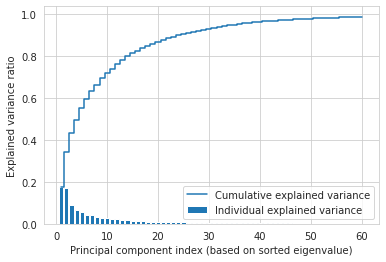

In [52]:
  n_all=60
  pca_all = PCA(n_components=n_all)
  mini_train_pca_all = pca_all.fit_transform(mini_train_data)

  x_axis = range(1,n_all+1)
  y_axis = pca_all.explained_variance_ratio_
  plt.bar(x_axis, y_axis, label='Individual explained variance')
  plt.step(x_axis, np.cumsum(y_axis), where='mid', label='Cumulative explained variance')

  plt.legend()
  plt.ylabel('Explained variance ratio');
  plt.xlabel('Principal component index (based on sorted eigenvalue)');


In [53]:
pipe_slr = make_pipeline(PCA(n_components=25),LinearRegression())
pipe_slr.fit(mini_train_data, mini_train_labels.ravel())
y_pred_slr = pipe_slr.predict(dev_data)
y_pred_slr_aux = np.where(y_pred_slr >= 0.5, 1, 0)
error = (dev_labels.ravel() != y_pred_slr_aux).sum()/len(y_pred_slr_aux)
print('Test Accuracy: %.3f' % (1-error))

Test Accuracy: 0.512


In [54]:
# ols w/PCA
horse_race['model'].append("OLS w/PCA")
horse_race['accuracy'].append((1-error))
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_slr_aux,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |
| 10 | OLS w/PCA                |    0.51192 |   214.8   |


### Logistic Regression with PCA

In [55]:
pca = PCA(n_components=25, svd_solver='full')
pca.fit(mini_train_data)
print(pca.explained_variance_ratio_)
print('\nPercentage of the variance explained by the first %.0f components: %.2f' % (pca.n_components_,pca.explained_variance_ratio_.sum()))

[0.17428033 0.16856582 0.08885598 0.06476538 0.05646671 0.04170069
 0.03965531 0.03047246 0.02907398 0.02542794 0.02129209 0.0207721
 0.01986265 0.01857002 0.0141855  0.01253971 0.01163271 0.01097178
 0.01004188 0.00954504 0.00853685 0.00798363 0.00738177 0.00691578
 0.00631778]

Percentage of the variance explained by the first 25 components: 0.91


In [56]:
pipe_lr = make_pipeline(PCA(n_components=25),LogisticRegression(random_state=1, solver = 'lbfgs'))
pipe_lr.fit(mini_train_data, mini_train_labels.ravel())
y_pred_lr = pipe_lr.predict(dev_data)
error_lr = (dev_labels.ravel() != y_pred_lr).sum()/len(y_pred_lr)
print('Test Accuracy: %.3f' % pipe_lr.score(dev_data, dev_labels))

Test Accuracy: 0.512


In [57]:
# Logistic w/PCA
horse_race['model'].append("Logistic w/PCA")
horse_race['accuracy'].append((1-error_lr))
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_lr,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |
| 10 | OLS w/PCA                |    0.51192 |   214.8   |
| 11 | Logistic w/PCA           |    0.51192 |   235.048 |


### OLS

In [58]:
slr = LinearRegression()
slr.fit(mini_train_data, mini_train_labels.ravel())
y_pred_ols = slr.predict(dev_data)
y_pred_ols_aux = np.where(y_pred_ols >= 0.5, 1, 0)
error_ols = (dev_labels.ravel() != y_pred_ols_aux).sum()/len(y_pred_ols_aux)
print('Test Accuracy: %.4f' % (1-error_ols))

Test Accuracy: 0.5166


In [59]:
# ols
horse_race['model'].append("OLS")
horse_race['accuracy'].append((1-error_ols))
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_ols_aux,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |
| 10 | OLS w/PCA                |    0.51192 |   214.8   |
| 11 | Logistic w/PCA           |    0.51192 |   235.048 |
| 12 | OLS                      |    0.51664 |   481.908 |


### Ridge Regression

In [60]:
ridge = Ridge(alpha=1.0)
ridge.fit(mini_train_data, mini_train_labels.ravel())
y_pred_rdg = ridge.predict(dev_data)
y_pred_rdg_aux = np.where(y_pred_rdg >= 0.5, 1, 0)
error_rdg = (dev_labels.ravel() != y_pred_rdg_aux).sum()/len(y_pred_rdg_aux)
print('Test Accuracy: %.4f' % (1-error_rdg))

Test Accuracy: 0.5168


In [61]:
# ridge
horse_race['model'].append("Ridge Regression")
horse_race['accuracy'].append((1-error_rdg))
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_rdg_aux,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |
| 10 | OLS w/PCA                |    0.51192 |   214.8   |
| 11 | Logistic w/PCA           |    0.51192 |   235.048 |
| 12 | OLS                      |    0.51664 |   481.908 |
| 13 | Ridge Regression         |    0.51682 |   485.005 |


### Lasso

In [62]:
lasso = Ridge(alpha=1.0)
lasso.fit(mini_train_data, mini_train_labels.ravel())
y_pred_lasso = lasso.predict(dev_data)
y_pred_lasso_aux = np.where(y_pred_lasso >= 0.5, 1, 0)
error_lasso = (dev_labels.ravel() != y_pred_lasso_aux).sum()/len(y_pred_lasso_aux)
print('Test Accuracy: %.4f' % (1-error_lasso))

Test Accuracy: 0.5168


In [63]:
# lasso
horse_race['model'].append("Lasso")
horse_race['accuracy'].append((1-error_lasso))
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_lasso_aux,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |
| 10 | OLS w/PCA                |    0.51192 |   214.8   |
| 11 | Logistic w/PCA           |    0.51192 |   235.048 |
| 12 | OLS                      |    0.51664 |   481.908 |
| 13 | Ridge Regression         |    0.51682 |   485.005 |
| 14 | Lasso                    |    0.51682 |   485.005

### Elastic Net

In [64]:
elanet = ElasticNet(alpha=1.0, l1_ratio = 0.5)
elanet.fit(mini_train_data, mini_train_labels.ravel())
y_pred_elanet = elanet.predict(dev_data)
y_pred_elanet_aux = np.where(y_pred_elanet >= 0.5, 1, 0)
error_elanet = (dev_labels.ravel() != y_pred_elanet_aux).sum()/len(y_pred_elanet_aux)
print('Test Accuracy: %.3f' % (1-error_elanet))

Test Accuracy: 0.506


In [65]:
# elastic net
horse_race['model'].append("Elastic Net")
horse_race['accuracy'].append((1-error_elanet))
horse_race['utility'].append(utility(dev_weights,dev_resps,y_pred_elanet_aux,dev_dates  ))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |
| 10 | OLS w/PCA                |    0.51192 |   214.8   |
| 11 | Logistic w/PCA           |    0.51192 |   235.048 |
| 12 | OLS                      |    0.51664 |   481.908 |
| 13 | Ridge Regression         |    0.51682 |   485.005 |
| 14 | Lasso                    |    0.51682 |   485.005

### Comparison of Runtime and Accuracy

In [66]:
test_size = 10000
train_sizes = list(range(20000,400000,20000))

#Define vectors to hold accuracies and runtimes for each model
rfaf_acc = []
rfaf_t = []

rflr_acc = []
rflr_acc = []
knn_acc = []

bnb_acc = []
bnb_t = []

mnb_acc = []
mnb_t = []

olspca_acc = []
lrpca_acc = []

ols_acc = []
ols_t = []

rr_acc = []
rr_t = []

lass_acc = []
lass_t = []

en_acc = []
en_t = []

accuracies = []

for i in train_sizes:
  """Test all models on a range of training data sizes. Compute runtime and accuracy"""

  ts_train_data, ts_train_labels = X_train[0:i], y_train[0:i]
  ts_test_data, ts_test_labels = X_train[i:i+test_size], y_train[i:i+test_size]
  
  #Random Forest
  t1 = time.time()
  clf = RandomForestClassifier(n_estimators = 10, random_state = 0, n_jobs = -1)
  clf = clf.fit(ts_train_data, ts_train_labels.ravel())
  y_pred_rf = clf.predict(ts_test_data)
  y_pred_rf_aux = np.where(y_pred_rf >= 0.5, 1, 0)
  error_rf = (ts_test_labels.ravel() != y_pred_rf_aux).sum()/len(y_pred_rf_aux)
  t2 = time.time()
  rfaf_acc.append(1-error_rf)
  rfaf_t.append(t2-t1)

  #BNB
  t1 = time.time()
  bnb = BernoulliNB()
  bnb.fit(ts_train_data, ts_train_labels.ravel())
  y_pred_bnb = bnb.predict(ts_test_data)
  y_pred_bnb_aux = np.where(y_pred_bnb >= 0.5, 1, 0)
  error_bnb = (ts_test_labels.ravel() != y_pred_bnb_aux).sum()/len(y_pred_bnb_aux)
  t2 = time.time()
  bnb_acc.append(1-error_bnb)
  bnb_t.append(t2-t1)

  #OLS
  t1 = time.time()
  slr = LinearRegression()
  slr.fit(ts_train_data, ts_train_labels.ravel())
  y_pred_ols = slr.predict(ts_test_data)
  y_pred_ols_aux = np.where(y_pred_ols >= 0.5, 1, 0)
  error_ols = (ts_test_labels.ravel() != y_pred_ols_aux).sum()/len(y_pred_ols_aux)
  t2 = time.time()
  ols_acc.append(1-error_ols)
  ols_t.append(t2-t1)

  # Ridge Regression
  t1 = time.time()
  ridge = Ridge(alpha=1.0)
  ridge.fit(ts_train_data, ts_train_labels.ravel())
  y_pred_rdg = ridge.predict(ts_test_data)
  y_pred_rdg_aux = np.where(y_pred_rdg >= 0.5, 1, 0)
  error_rdg = (ts_test_labels.ravel() != y_pred_rdg_aux).sum()/len(y_pred_rdg_aux)
  t2 = time.time()
  rr_acc.append(1-error_rdg)
  rr_t.append(t2-t1)

  # Lasso
  t1 = time.time()
  lasso = Ridge(alpha=1.0)
  lasso.fit(ts_train_data, ts_train_labels.ravel())
  y_pred_lasso = lasso.predict(ts_test_data)
  y_pred_lasso_aux = np.where(y_pred_lasso >= 0.5, 1, 0)
  error_lasso = (ts_test_labels.ravel() != y_pred_lasso_aux).sum()/len(y_pred_lasso_aux)
  t2 = time.time()
  lass_acc.append(1-error_lasso)
  lass_t.append(t2-t1)

  # Elastic Net
  t1 = time.time()
  elanet = ElasticNet(alpha=1.0, l1_ratio = 0.5)
  elanet.fit(ts_train_data, ts_train_labels.ravel())
  y_pred_elanet = elanet.predict(ts_test_data)
  y_pred_elanet_aux = np.where(y_pred_elanet >= 0.5, 1, 0)
  error_elanet = (ts_test_labels.ravel() != y_pred_elanet_aux).sum()/len(y_pred_elanet_aux)
  t2 = time.time()
  en_acc.append(1-error_elanet)
  en_t.append(t2-t1)

  print("Loop Complete")


Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete


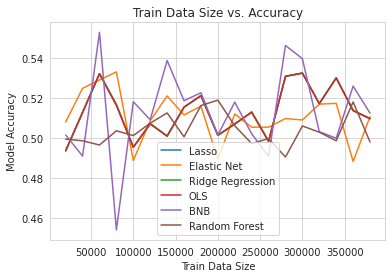

In [67]:
#Plot Train Data Size vs Accuracy for all models
plt.plot(train_sizes, lass_acc)
plt.plot(train_sizes, en_acc)
plt.plot(train_sizes, rr_acc)
plt.plot(train_sizes, ols_acc)
plt.plot(train_sizes, bnb_acc)
plt.plot(train_sizes, rfaf_acc)
plt.title("Train Data Size vs. Accuracy")
plt.legend(['Lasso','Elastic Net','Ridge Regression','OLS','BNB','Random Forest'])
plt.xlabel("Train Data Size")
plt.ylabel("Model Accuracy")
plt.show()

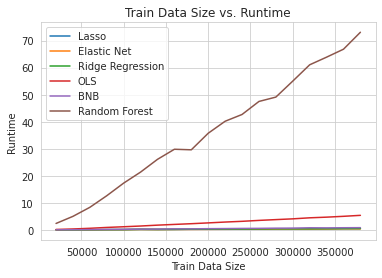

In [68]:
#Plot Train Data Size vs. Runtime for all models
plt.plot(train_sizes, lass_t)
plt.plot(train_sizes, en_t)
plt.plot(train_sizes, rr_t)
plt.plot(train_sizes, ols_t)
plt.plot(train_sizes, bnb_t)
plt.plot(train_sizes, rfaf_t)
plt.title("Train Data Size vs. Runtime")
plt.legend(['Lasso','Elastic Net','Ridge Regression','OLS','BNB', 'Random Forest'])
plt.xlabel("Train Data Size")
plt.ylabel("Runtime")
plt.show()

## Long Short-Term Memory Neural Network (LSTM)

We first check whether GPUs are available in collab and load keras packages

In [ ]:
#LSTM model

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

Found GPU at: /device:GPU:0


In [ ]:
tf.test.gpu_device_name()

''

To reduce the dimensionality, we applied PCA given that only 25 features explain at least 90% of the variance 

In [ ]:
pca_lstm = PCA(n_components=25)
mini_train_pca_lstm = pca_lstm.fit_transform(mini_train_data)
dev_data_pca_lstm = pca_lstm.transform(dev_data)

In [ ]:
#Reshape the data into 3-D array
mini_train_data_3d = np.reshape(mini_train_pca_lstm, (mini_train_pca_lstm.shape[0],mini_train_pca_lstm.shape[1],1))
dev_data_3d = np.reshape(dev_data_pca_lstm, (dev_data_pca_lstm.shape[0],dev_data_pca_lstm.shape[1],1))

In [ ]:
# Initialising the RNN
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (mini_train_data_3d.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and Dropout layer
model.add(LSTM(units = 50,  return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and Dropout layer
model.add(LSTM(units = 50,  return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and and Dropout layer
model.add(LSTM(units = 50 ))
model.add(Dropout(0.2))

# Adding the output layer
# For Full connection layer we use dense
# As the output is 1D so we use unit=1
model.add(Dense(units = 1, activation='sigmoid'))


First, we need to define the batch size and the number of epoch for the model.  According to the definition of the model, the batch size is a number of samples processed before the model is updated and the number of epochs is the number of complete passes through the training dataset.  The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset.  For the mini training data set, we have approximately 50K entries and one day have approximately 500 entries.  To reduce some of the noise, we want to set the batch size to a number of samples equal to one week (i.e. 7x500 = 3500).

In [ ]:
#compile and fit the model on x number of epochs

epochs = [  2000]
batch_size = [3500]
accuracy_list = []
model_list=[]
utility_list=[]
for i in range(len(epochs)):
  for j in range(len(batch_size)):
    with tf.device('/device:GPU:0'):
      model.compile(optimizer = 'adam', loss = 'mean_squared_error')
      model.fit(mini_train_data_3d, mini_train_labels.ravel(), epochs = epochs[i], batch_size = batch_size[j])
      y_pred_lstm = model.predict(dev_data_3d)
      y_pred_lstm_aux = np.where(y_pred_lstm >= 0.5, 1, 0)
      accuracy_lstm = accuracy_score(dev_labels.ravel(), y_pred_lstm_aux.ravel())
      model_list.append('LSTM '+str(epochs[i])+' epochs '+str(batch_size[j])+' batch size')
      accuracy_list.append(accuracy_lstm)
      utility_list.append(utility(dev_weights,dev_resps,y_pred_lstm_aux.T[0],dev_dates  ))

Epoch 1/2000
15/15 [==============================] - 5s 22ms/step - loss: 0.1578
Epoch 2/2000
15/15 [==============================] - 0s 21ms/step - loss: 0.1580
Epoch 3/2000
15/15 [==============================] - 0s 21ms/step - loss: 0.1559
Epoch 4/2000
15/15 [==============================] - 0s 21ms/step - loss: 0.1567
Epoch 5/2000
15/15 [==============================] - 0s 21ms/step - loss: 0.1558
Epoch 6/2000
15/15 [==============================] - 0s 21ms/step - loss: 0.1578
Epoch 7/2000
15/15 [==============================] - 0s 21ms/step - loss: 0.1559
Epoch 8/2000
15/15 [==============================] - 0s 21ms/step - loss: 0.1565
Epoch 9/2000
15/15 [==============================] - 0s 21ms/step - loss: 0.1569
Epoch 10/2000
15/15 [==============================] - 0s 21ms/step - loss: 0.1559
Epoch 11/2000
15/15 [==============================] - 0s 21ms/step - loss: 0.1547
Epoch 12/2000
15/15 [==============================] - 0s 21ms/step - loss: 0.1555
Epoch 13/2000

In [ ]:
horse_race_lstm={}
horse_race_lstm['model']=model_list
horse_race_lstm['accuracy']=accuracy_list
horse_race_lstm['utility']=utility_list
print(tabulate(pd.DataFrame(horse_race_lstm), tablefmt="pipe", headers="keys"))

|    | model                           |   accuracy |   utility |
|---:|:--------------------------------|-----------:|----------:|
|  0 | LSTM 100 epochs 3500 batch size |    0.5135  |   214.106 |
|  1 | LSTM 500 epochs 3500 batch size |    0.50495 |   198.157 |


Output Array in terms of Epochs, Batch Size, and Accuracy:

- [1, 25, 0.50308, 1, 50, 0.50398, 5, 25, 0.50224, 5, 50, 0.50256, 10, 25, 0.50256, 10, 50, 0.50224, 20, 25, 0.50224, 20, 50, 0.50244, 30, 25, 0.5029, 30, 50, 0.51036]
- Best accuracy of LSTM: 51.036% with 30 Epochs and 50 batch size.

- Higher Batch sizes do not improve the model (e.g. 100 batches). Best is still around 50.2% accuracy.

- [1, 50, 0.50224, 1, 100, 0.50226, 5, 50, 0.50224, 5, 100, 0.50224, 10, 50, 0.50224, 10, 100, 0.50224, 20, 50, 0.50224, 20, 100, 0.50218, 30, 50, 0.50236, 30, 100, 0.5025]

The number of epochs is the number of times the model will cycle through the data. The more epochs we run, the more the model will improve, up to a certain point. After that point, the model will stop improving during each epoch. For our model, we will set the number of epochs to 3.




## Convolutional Neural Network (CNN)




In [13]:
# Import libraries needed for CNN
#import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling2D

Xtrain shape: (50000, 126)
Ytrain shape: (50000, 1)
Xtest shape: (50000, 126)
Ytest shape: (50000, 1)
Xtrain NEW shape: (50000, 126, 1)
Xtest NEW shape: (50000, 126, 1)
Ytrain NEW shape: (50000, 1, 1)
Ytest NEW shape: (50000, 1, 1)
Epoch 1/3
1000/1000 [==============================] - 37s 4ms/step - loss: 0.6943 - accuracy: 0.5131 - val_loss: 0.6934 - val_accuracy: 0.5014
Epoch 2/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6901 - accuracy: 0.5292 - val_loss: 0.6929 - val_accuracy: 0.5115
Epoch 3/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6897 - accuracy: 0.5283 - val_loss: 0.6951 - val_accuracy: 0.5069


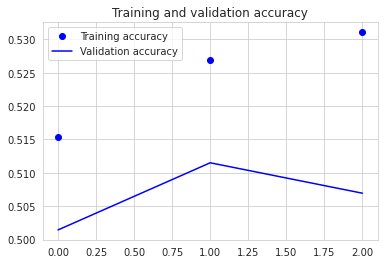

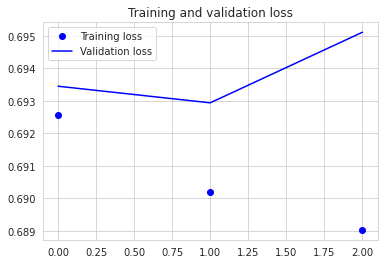

Validation Accuracy List for each epoch: [0.5014399886131287, 0.5115000009536743, 0.5069400072097778]
Devdata NEW shape: (50000, 126, 1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Predicted classes:  [1 1 1 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|
|  0 | CNN Model |     0.5115 |    370.15 |             1 |              2 |
Epoch 1/3
1000/1000 [==============================] - 5s 4ms/step - loss: 0.8662 - accuracy: 0.4396 - val_loss: 0.7277 - val_accuracy: 0.5056
Epoch 2/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.7202 - accuracy: 0.5084 - val_loss: 0.7069 - val_accuracy: 0.5056
Epoch 3/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.7045 - accuracy: 0.5117 - val_loss: 0.7003 - val_accuracy: 0.5056


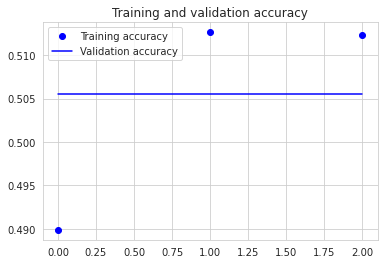

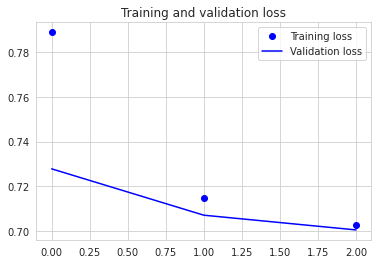

Validation Accuracy List for each epoch: [0.5055800080299377, 0.5055800080299377, 0.5055800080299377]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [1 1 1 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|
|  0 | CNN Model |    0.5115  |   370.15  |             1 |              2 |
|  1 | CNN Model |    0.50558 |   591.102 |             1 |              3 |
Epoch 1/3
1000/1000 [==============================] - 5s 4ms/step - loss: 1.2310 - accuracy: 0.3207 - val_loss: 0.7450 - val_accuracy: 0.5056
Epoch 2/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.7305 - accuracy: 0.5103 - val_loss: 0.7086 - val_accuracy: 0.5056
Epoch 3/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.7056 - accuracy: 0.5116 - val_loss: 0.7006 - val_accuracy: 0.5056


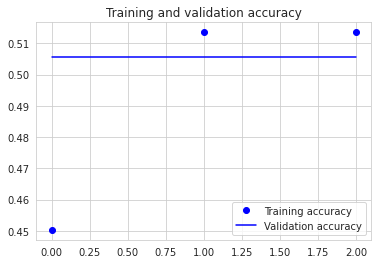

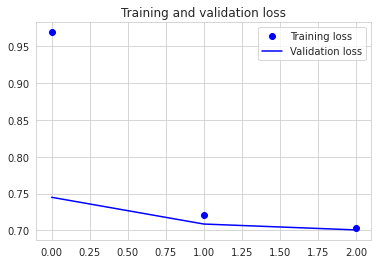

Validation Accuracy List for each epoch: [0.5055800080299377, 0.5055800080299377, 0.5055800080299377]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [1 1 1 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|
|  0 | CNN Model |    0.5115  |   370.15  |             1 |              2 |
|  1 | CNN Model |    0.50558 |   591.102 |             1 |              3 |
|  2 | CNN Model |    0.50558 |   591.102 |             1 |              4 |
Epoch 1/3
1000/1000 [==============================] - 5s 4ms/step - loss: 0.6927 - accuracy: 0.5220 - val_loss: 0.6947 - val_accuracy: 0.5058
Epoch 2/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6850 - accuracy: 0.5401 - val_loss: 0.6963 - val_accuracy: 0.5188
Epoch 3/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6746 - accuracy: 0.5615 - val_loss: 0.7002 - val_accuracy: 0.5084


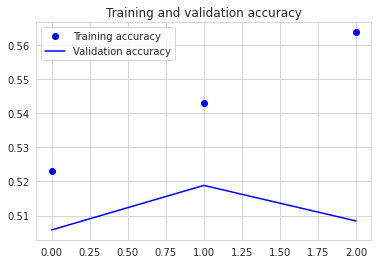

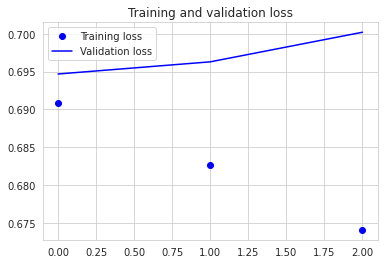

Validation Accuracy List for each epoch: [0.5058199763298035, 0.5188400149345398, 0.5084400177001953]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [0 1 0 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|
|  0 | CNN Model |    0.5115  |   370.15  |             1 |              2 |
|  1 | CNN Model |    0.50558 |   591.102 |             1 |              3 |
|  2 | CNN Model |    0.50558 |   591.102 |             1 |              4 |
|  3 | CNN Model |    0.51884 |   179.267 |             3 |              2 |
Epoch 1/3
1000/1000 [==============================] - 5s 4ms/step - loss: 0.8116 - accuracy: 0.5241 - val_loss: 0.7108 - val_accuracy: 0.5079
Epoch 2/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6967 - accuracy: 0.5523 - val_loss: 0.7041 - val_accuracy: 0.5106
Epoch 3/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.

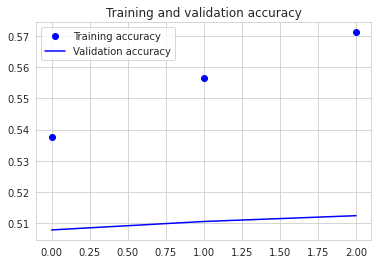

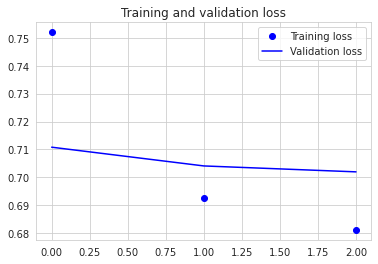

Validation Accuracy List for each epoch: [0.507860004901886, 0.5105599761009216, 0.5124199986457825]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [1 1 1 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|
|  0 | CNN Model |    0.5115  |   370.15  |             1 |              2 |
|  1 | CNN Model |    0.50558 |   591.102 |             1 |              3 |
|  2 | CNN Model |    0.50558 |   591.102 |             1 |              4 |
|  3 | CNN Model |    0.51884 |   179.267 |             3 |              2 |
|  4 | CNN Model |    0.51242 |   224.687 |             3 |              3 |
Epoch 1/3
1000/1000 [==============================] - 5s 4ms/step - loss: 0.9970 - accuracy: 0.4961 - val_loss: 0.7248 - val_accuracy: 0.5056
Epoch 2/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.7159 - accuracy: 0.5141 - val_loss: 0.7027 - val_accuracy: 0.5056
E

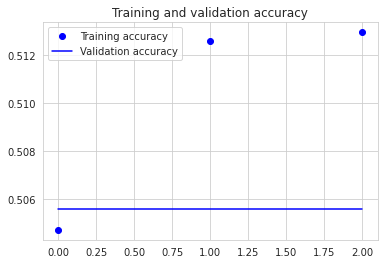

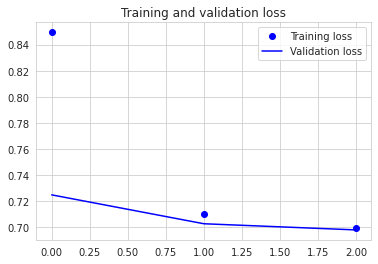

Validation Accuracy List for each epoch: [0.5055800080299377, 0.5055800080299377, 0.5055800080299377]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [1 1 1 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|
|  0 | CNN Model |    0.5115  |   370.15  |             1 |              2 |
|  1 | CNN Model |    0.50558 |   591.102 |             1 |              3 |
|  2 | CNN Model |    0.50558 |   591.102 |             1 |              4 |
|  3 | CNN Model |    0.51884 |   179.267 |             3 |              2 |
|  4 | CNN Model |    0.51242 |   224.687 |             3 |              3 |
|  5 | CNN Model |    0.50558 |   591.102 |             3 |              4 |
Epoch 1/3
1000/1000 [==============================] - 5s 4ms/step - loss: 0.6926 - accuracy: 0.5214 - val_loss: 0.6949 - val_accuracy: 0.5094
Epoch 2/3
1000/1000 [==============================] - 4s 4ms/step

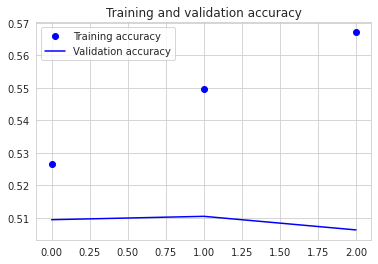

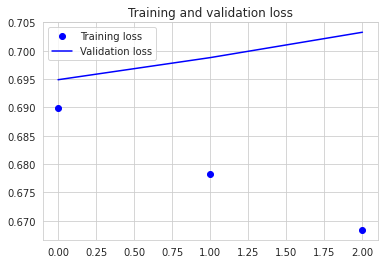

Validation Accuracy List for each epoch: [0.509440004825592, 0.5104799866676331, 0.5062999725341797]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [1 1 0 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|
|  0 | CNN Model |    0.5115  |   370.15  |             1 |              2 |
|  1 | CNN Model |    0.50558 |   591.102 |             1 |              3 |
|  2 | CNN Model |    0.50558 |   591.102 |             1 |              4 |
|  3 | CNN Model |    0.51884 |   179.267 |             3 |              2 |
|  4 | CNN Model |    0.51242 |   224.687 |             3 |              3 |
|  5 | CNN Model |    0.50558 |   591.102 |             3 |              4 |
|  6 | CNN Model |    0.51048 |   194.786 |             5 |              2 |
Epoch 1/3
1000/1000 [==============================] - 5s 4ms/step - loss: 0.9542 - accuracy: 0.5246 - val_loss: 0.7483 - val_accurac

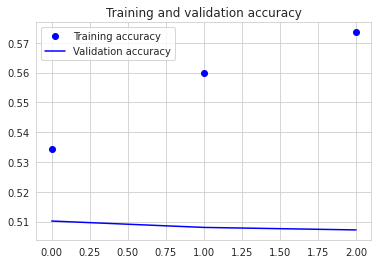

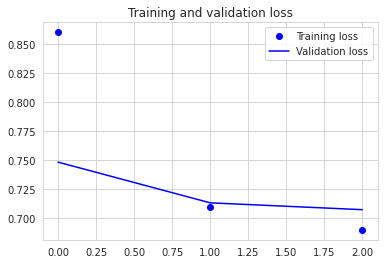

Validation Accuracy List for each epoch: [0.510200023651123, 0.5080599784851074, 0.5072199702262878]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [1 1 1 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|
|  0 | CNN Model |    0.5115  |   370.15  |             1 |              2 |
|  1 | CNN Model |    0.50558 |   591.102 |             1 |              3 |
|  2 | CNN Model |    0.50558 |   591.102 |             1 |              4 |
|  3 | CNN Model |    0.51884 |   179.267 |             3 |              2 |
|  4 | CNN Model |    0.51242 |   224.687 |             3 |              3 |
|  5 | CNN Model |    0.50558 |   591.102 |             3 |              4 |
|  6 | CNN Model |    0.51048 |   194.786 |             5 |              2 |
|  7 | CNN Model |    0.5102  |   314.596 |             5 |              3 |
Epoch 1/3
1000/1000 [==============================] - 5

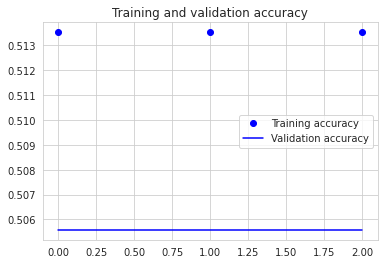

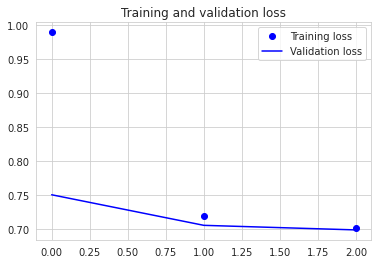

Validation Accuracy List for each epoch: [0.5055800080299377, 0.5055800080299377, 0.5055800080299377]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [1 1 1 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|
|  0 | CNN Model |    0.5115  |   370.15  |             1 |              2 |
|  1 | CNN Model |    0.50558 |   591.102 |             1 |              3 |
|  2 | CNN Model |    0.50558 |   591.102 |             1 |              4 |
|  3 | CNN Model |    0.51884 |   179.267 |             3 |              2 |
|  4 | CNN Model |    0.51242 |   224.687 |             3 |              3 |
|  5 | CNN Model |    0.50558 |   591.102 |             3 |              4 |
|  6 | CNN Model |    0.51048 |   194.786 |             5 |              2 |
|  7 | CNN Model |    0.5102  |   314.596 |             5 |              3 |
|  8 | CNN Model |    0.50558 |   591.102 |            

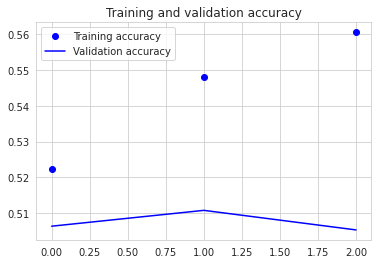

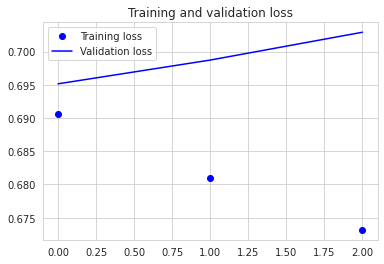

Validation Accuracy List for each epoch: [0.5063599944114685, 0.5107799768447876, 0.5053200125694275]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [0 1 0 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|
|  0 | CNN Model |    0.5115  |  370.15   |             1 |              2 |
|  1 | CNN Model |    0.50558 |  591.102  |             1 |              3 |
|  2 | CNN Model |    0.50558 |  591.102  |             1 |              4 |
|  3 | CNN Model |    0.51884 |  179.267  |             3 |              2 |
|  4 | CNN Model |    0.51242 |  224.687  |             3 |              3 |
|  5 | CNN Model |    0.50558 |  591.102  |             3 |              4 |
|  6 | CNN Model |    0.51048 |  194.786  |             5 |              2 |
|  7 | CNN Model |    0.5102  |  314.596  |             5 |              3 |
|  8 | CNN Model |    0.50558 |  591.102  |            

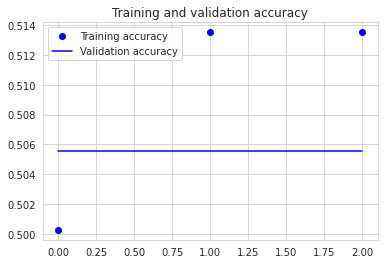

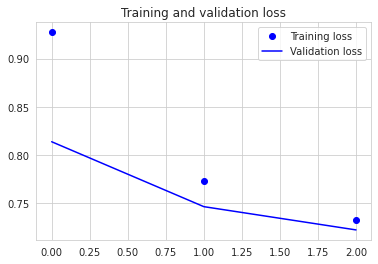

Validation Accuracy List for each epoch: [0.5055800080299377, 0.5055800080299377, 0.5055800080299377]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [1 1 1 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|
|  0 | CNN Model |    0.5115  |  370.15   |             1 |              2 |
|  1 | CNN Model |    0.50558 |  591.102  |             1 |              3 |
|  2 | CNN Model |    0.50558 |  591.102  |             1 |              4 |
|  3 | CNN Model |    0.51884 |  179.267  |             3 |              2 |
|  4 | CNN Model |    0.51242 |  224.687  |             3 |              3 |
|  5 | CNN Model |    0.50558 |  591.102  |             3 |              4 |
|  6 | CNN Model |    0.51048 |  194.786  |             5 |              2 |
|  7 | CNN Model |    0.5102  |  314.596  |             5 |              3 |
|  8 | CNN Model |    0.50558 |  591.102  |            

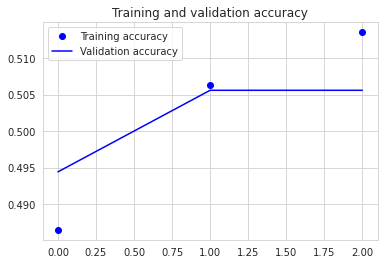

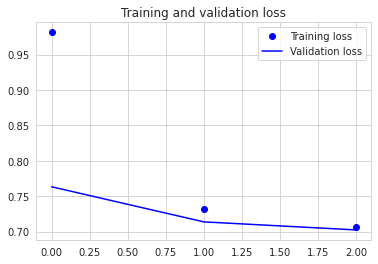

Validation Accuracy List for each epoch: [0.49441999197006226, 0.5055800080299377, 0.5055800080299377]
Devdata NEW shape: (50000, 126, 1)
Predicted classes:  [1 1 1 ... 1 1 1]
|    | model     |   accuracy |   utility |   kernel_size |   density_size |
|---:|:----------|-----------:|----------:|--------------:|---------------:|
|  0 | CNN Model |    0.5115  |  370.15   |             1 |              2 |
|  1 | CNN Model |    0.50558 |  591.102  |             1 |              3 |
|  2 | CNN Model |    0.50558 |  591.102  |             1 |              4 |
|  3 | CNN Model |    0.51884 |  179.267  |             3 |              2 |
|  4 | CNN Model |    0.51242 |  224.687  |             3 |              3 |
|  5 | CNN Model |    0.50558 |  591.102  |             3 |              4 |
|  6 | CNN Model |    0.51048 |  194.786  |             5 |              2 |
|  7 | CNN Model |    0.5102  |  314.596  |             5 |              3 |
|  8 | CNN Model |    0.50558 |  591.102  |           

In [14]:
# Define different sizes for trial and error
# N_size of 20K or 70K does not perform as well as 50K 
n_size = [50000]
kernel_sizes = [1, 3, 5, 10]
dense_sizes = [2, 3, 4]

# Create empty dict exclusive to CNN to save accuracy, utilities, and parameters to perform hyperparameter tuning later
horse_race_cnn = {'model' : [], 'accuracy' : [], 'utility' : [], 
             'kernel_size' : [], 'density_size' : []}

# Source: https://webcache.googleusercontent.com/search?q=cache:O_aNQyJ29XMJ:https://missinglink.ai/guides/convolutional-neural-networks/python-convolutional-neural-network-creating-cnn-keras-tensorflow-plain-python/+&cd=1&hl=en&ct=clnk&gl=us
# Source: https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
# Source: https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f
# Loop through different sizes. However, since our unique dates has a size of 50,000, we are going to stick with n=50000 in our data set.
for i in range(len(n_size)):
    # Define train and test sets, size of 50K each
    X_train2 = mini_train_data
    y_train2 = mini_train_labels

    X_test2 = dev_data
    y_test2 = dev_labels

    # Training set
    print("Xtrain shape:", X_train2.shape)
    print("Ytrain shape:", y_train2.shape)
    # Validation data
    print("Xtest shape:", X_test2.shape)
    print("Ytest shape:", y_test2.shape)

    # Source: https://stackoverflow.com/questions/40464403/tensorflow-convolution-neural-network-with-non-image-input
    # Source: https://stackoverflow.com/questions/50918713/convolution-neural-network-using-sequential-model-for-non-image-data
    # Since we're going by a row-to-row basis in this case (using Conv1D for returns as opposed to Conv2D for images), we don't actually have a 2nd dimension. 
    # Therefore, we need to add an extra dimension and it will consider the height of the tensor to be 1, which works like a [1xn] shaped filter, striding across the entire row (only in horizontal direction).
    X_train2 = np.array(X_train2)
    X_train2 = X_train2.astype('float32').reshape(X_train2.shape[0], X_train2.shape[1], 1)
    print("Xtrain NEW shape:", X_train2.shape)
    X_test2 = np.array(X_test2)
    X_test2 = X_test2.astype('float32').reshape(X_test2.shape[0], X_test2.shape[1], 1)
    print("Xtest NEW shape:", X_test2.shape)

    # We add that extra dimension with a height of 1 to the test data as well.
    y_train2 = np.array(y_train2)
    y_train2 = y_train2.astype('float32').reshape(y_train2.shape[0], y_train2.shape[1], 1)
    print("Ytrain NEW shape:", y_train2.shape)
    y_test2 = np.array(y_test2)
    y_test2 = y_test2.astype('float32').reshape(y_test2.shape[0], y_test2.shape[1], 1)
    print("Ytest NEW shape:", y_test2.shape)
    
    # Loop through all kernel sizes
    for j in range(len(kernel_sizes)):
        
        # Source: https://stackoverflow.com/questions/57751417/what-is-meant-by-sequential-model-in-keras#:~:text=The%20sequential%20API%20allows%20you,by%2Dlayer%20for%20most%20problems.&text=Alternatively%2C%20the%20functional%20API%20allows,the%20previous%20and%20next%20layers.
        # The Sequential model is a linear stack of layers.
        # The sequential API allows us to create models layer-by-layer for most problems.
        model = Sequential()

        # Source: https://stackoverflow.com/questions/50918713/convolution-neural-network-using-sequential-model-for-non-image-data
        # Source: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
        # Add model layers. Again, we are using Conv1D since we are not working with images.
        # Rectified Linear Activation has been proven to work well in neural networks.
        model.add(Conv1D(64, kernel_size=kernel_sizes[j], activation='relu', input_shape=(X_train2.shape[1], 1)))
        model.add(Conv1D(32, kernel_size=kernel_sizes[j], activation='relu'))

        # Flatten serves as a connection between the convolution and dense layers.
        model.add(Flatten())

        # Loop through all density sizes
        for k in range(len(dense_sizes)):
            
            # We use sigmoid activation due to the binary nature of our outcomes: 1 if action, 0 if no action.
            model.add(Dense(dense_sizes[k], activation='sigmoid'))
        
            # Source: https://stackoverflow.com/questions/63456418/keras-valueerror-logits-and-labels-must-have-the-same-shape-none-2-vs-non
            # Compile model using accuracy to measure model performance
            # The adam optimizer adjusts the learning rate throughout training.
            # A lower loss = better model performance.
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            # Source: https://deepai.org/machine-learning-glossary-and-terms/epoch
            # Train the model
            # Epochs: # of times the model will cycle through the data. The more epochs we run, the more the model will improve, up to a certain point. 
            # Performance looks like it tops out at 3 epochs.
            history = model.fit(X_train2, y_train2, batch_size=50, validation_data=(X_test2, y_test2),
                      epochs=3)

            # Source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
            # Source: https://github.com/tflearn/tflearn/issues/357#:~:text=val_acc%20is%20the%20accuracy%20computed,you%20ahve%20to%20use%20batches. https://stackoverflow.com/questions/51344839/what-is-the-difference-between-the-terms-accuracy-and-validation-accuracy
            # Plot accuracy and loss over time (after each epoch iteration)
            accuracy = history.history['accuracy']
            val_accuracy = history.history['val_accuracy']
            loss = history.history['loss']
            val_loss = history.history['val_loss']
            epochs = range(len(accuracy))
            plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
            plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
            plt.title('Training and validation accuracy')
            plt.legend()
            plt.figure()
            plt.plot(epochs, loss, 'bo', label='Training loss')
            plt.plot(epochs, val_loss, 'b', label='Validation loss')
            plt.title('Training and validation loss')
            plt.legend()
            plt.show()

            print("Validation Accuracy List for each epoch:", history.history['val_accuracy'])

            # Source: https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/
            # Source: https://datascience.stackexchange.com/questions/46124/what-do-compile-fit-and-predict-do-in-keras-sequential-models
            # Similar to what we did for the x_train data above, we add a 3rd dimension (of height = 1) to dev_data.
            dev_data2 = np.array(dev_data)
            dev_data2 = dev_data2.astype('float32').reshape(dev_data2.shape[0], dev_data2.shape[1], 1)
            print("Devdata NEW shape:", dev_data2.shape)

            # Ensure that our predictions only contain 1's and 0's.
            prediction = model.predict_classes(dev_data2)
            print('Predicted classes: ', prediction)

            # Create a horse race table that contains each CNN Model's characteristics.
            horse_race_cnn['model'].append("CNN Model")
            horse_race_cnn['kernel_size'].append(kernel_sizes[j])
            horse_race_cnn['density_size'].append(dense_sizes[k])
            horse_race_cnn['accuracy'].append(max(history.history['val_accuracy']))
            horse_race_cnn['utility'].append(utility(dev_weights,dev_resps, prediction,dev_dates))
            print(tabulate(pd.DataFrame(horse_race_cnn), tablefmt="pipe", headers="keys"))

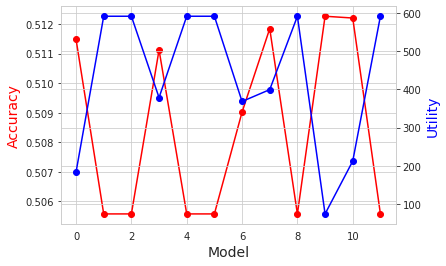

In [71]:
# Plot CNN model's accuracy and utility over iterations
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(horse_race_cnn['accuracy'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("Model",fontsize=14)
# set y-axis label
ax.set_ylabel("Accuracy",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(horse_race_cnn['utility'], color="blue", marker="o")
ax2.set_ylabel("Utility",color="blue",fontsize=14)

plt.show()

In [72]:
#print(horse_race_cnn['utility'])
#print(horse_race_cnn['accuracy'])

# Append the average utility score's CNN to the main horse race table.
# Find average out of all CNN models.
print(np.mean(horse_race_cnn['utility']))
print(np.mean(horse_race_cnn['accuracy']))

# # Append to horse_race table and print it out.
horse_race['model'].append("CNN Model")
horse_race['accuracy'].append(np.mean(horse_race_cnn['accuracy']))
horse_race['utility'].append(np.mean(horse_race_cnn['utility']))
print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

430.1482904962229
0.5084500014781952
|    | model                    |   accuracy |   utility |
|---:|:-------------------------|-----------:|----------:|
|  0 | Random Forest - All      |    0.5084  |   438.881 |
|  1 | Random Forest - Linear   |    0.50782 |   479.887 |
|  2 | Random Forest - Logistic |    0.5037  |   424.466 |
|  3 | 1-NN                     |    0.50612 |   429.17  |
|  4 | 3-NN                     |    0.50954 |   389.766 |
|  5 | 5-NN                     |    0.51038 |   435.564 |
|  6 | 7-NN                     |    0.511   |   403.517 |
|  7 | 9-NN                     |    0.50772 |   407.481 |
|  8 | NB Bernoulli             |    0.5264  |   462.223 |
|  9 | NB Multinomial           |    0.52196 |   372.814 |
| 10 | OLS w/PCA                |    0.51192 |   214.8   |
| 11 | Logistic w/PCA           |    0.51192 |   235.048 |
| 12 | OLS                      |    0.51664 |   481.908 |
| 13 | Ridge Regression         |    0.51682 |   485.005 |
| 14 | Lasso       

## Gaussian Mixture Model with Principal Component Analysis (GMM/PCA)

### Generate a GMM of varying component counts and covariance types
Notice that the model appears to be performing well with 2 GMM Components and regardless of covariance type. We'll move forward with 2-component models and ignore covariance type.

In [ ]:

for i in ['spherical','diag','tied','full']:
  for j in range(2,5):
    gm = GaussianMixture(n_components=j, covariance_type=i, random_state=12345)
    gm.fit(mini_train_data,mini_train_labels)
    pred = gm.predict(test_data)
    gmm_acc = round(accuracy_score(test_labels,pred),2)
    print("| Cov Type:",i[0:4],"| GMM Components:",j,"| Accuracy",gmm_acc,"|")

| Cov Type: sphe | GMM Components: 2 | Accuracy 0.49 |
| Cov Type: sphe | GMM Components: 3 | Accuracy 0.43 |
| Cov Type: sphe | GMM Components: 4 | Accuracy 0.29 |
| Cov Type: diag | GMM Components: 2 | Accuracy 0.51 |
| Cov Type: diag | GMM Components: 3 | Accuracy 0.42 |
| Cov Type: diag | GMM Components: 4 | Accuracy 0.27 |
| Cov Type: tied | GMM Components: 2 | Accuracy 0.51 |
| Cov Type: tied | GMM Components: 3 | Accuracy 0.29 |
| Cov Type: tied | GMM Components: 4 | Accuracy 0.29 |
| Cov Type: full | GMM Components: 2 | Accuracy 0.51 |
| Cov Type: full | GMM Components: 3 | Accuracy 0.43 |
| Cov Type: full | GMM Components: 4 | Accuracy 0.27 |


### Implement a Temporal Gridsearch
So far the Gaussian Mixture has already shown an accuracy above 50%, but this was only evaluated on a small section of the training data. We will perform a gridsearch along the time axis to verify that this type of model works equally throughout the dataset. Note: This type of Gridsearch does not optimize for hyperparameters, it merely evaluates consistancy across the entire range of the data.

In [ ]:
#Define a train data size, test data size
train_size = 50000
test_size = 20000

#Create a list of sequential train-test data slices
bookends = list(range(0,1500000,train_size+test_size))

#Define and empty list to store accuracies
accuracies = []

for i in range(len(bookends)-1):
  #Loop through all data slices. Run and test a 2-component GMM on each slice
  gm_train_data, gm_train_labels = X_train[bookends[i]:bookends[i+1]-test_size], y_train[bookends[i]:bookends[i+1]-test_size]
  gm_test_data, gm_test_labels = X_train[bookends[i]+train_size:bookends[i+1]], y_train[bookends[i]+train_size:bookends[i+1]]

  gm = GaussianMixture(n_components=2, covariance_type='diag', random_state=12345)
  gm.fit(gm_train_data,gm_train_labels)
  pred = gm.predict(gm_test_data)
  gmm_acc = round(accuracy_score(gm_test_labels,pred),2)
  
  #Append the model accuracy to the list and print its value
  accuracies.append(gmm_acc)
  print("Accuracy",gmm_acc)




Accuracy 0.48
Accuracy 0.51
Accuracy 0.5
Accuracy 0.5
Accuracy 0.49
Accuracy 0.52
Accuracy 0.49
Accuracy 0.5
Accuracy 0.51
Accuracy 0.48
Accuracy 0.5
Accuracy 0.52
Accuracy 0.52
Accuracy 0.46
Accuracy 0.53
Accuracy 0.48
Accuracy 0.52
Accuracy 0.54
Accuracy 0.5
Accuracy 0.52
Accuracy 0.5


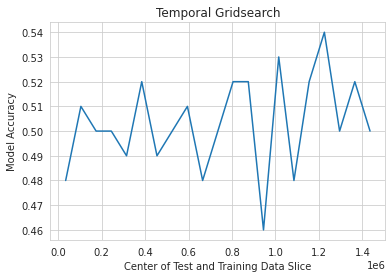

In [ ]:
x_vals = list(range(35000,1500000,70000))

#Plot Gridsearch Accuracies
plt.plot(x_vals,accuracies)
plt.xlabel("Center of Test and Training Data Slice")
plt.ylabel("Model Accuracy")
plt.title("Temporal Gridsearch")
plt.show()

By training and testing the data in small chunks along the full section of the data, we observe accuracies that range from 48-54% for the same number of principal components and covariance type. 

### Varying Training Data Size
Given that this is a time series, it may be the case that having more data doesn't necessarily mean a more accurate model. In this case, we modify the size of the training dataset while leaving the test size constant in an attempt to identify an optimal training data size.

In [ ]:
#Define a constant test size and a range of training sizes
test_size = 10000
train_sizes = list(range(20000,400000,20000))

#Create an empty list to store accuracies
accuracies = []

for i in train_sizes:
  #Loop through training data sizes, training and testing 2-component GMM models
  gm_train_data, gm_train_labels = X_train[0:i], y_train[0:i]
  gm_test_data, gm_test_labels = X_train[i:i+test_size], y_train[i:i+test_size]
  
  gm = GaussianMixture(n_components=2, covariance_type='diag', random_state=12345)
  gm.fit(gm_train_data,gm_train_labels)
  pred = gm.predict(gm_test_data)
  gmm_acc = accuracy_score(gm_test_labels,pred)
  
  #Append the model accuracy to the list and print its value
  accuracies.append(gmm_acc)
  print("Accuracy:", gmm_acc)


Accuracy: 0.5041
Accuracy: 0.4706
Accuracy: 0.4794
Accuracy: 0.5465
Accuracy: 0.5159
Accuracy: 0.4859
Accuracy: 0.4964
Accuracy: 0.48
Accuracy: 0.4765
Accuracy: 0.5016
Accuracy: 0.4806
Accuracy: 0.5027
Accuracy: 0.4919
Accuracy: 0.4759
Accuracy: 0.4791
Accuracy: 0.5131
Accuracy: 0.4925
Accuracy: 0.4859
Accuracy: 0.4898


As training size increases, there doesn't appear to be a predictable relationship between training data size and model accuracy.

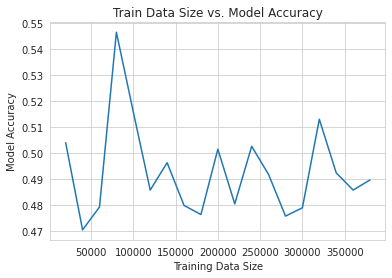

In [ ]:
plt.plot(train_sizes, accuracies)
plt.title("Train Data Size vs. Model Accuracy")
plt.xlabel("Training Data Size")
plt.ylabel("Model Accuracy")
plt.show()

### Principal Component Analysis

In [ ]:
exp_var = []

#Calculate explained variance for 1-98 principal components
k_values = list(range(1,80))
for k in k_values:
    pca = PCA(n_components=k)
    pca.fit(mini_train_data)
    exp_var.append(sum(pca.explained_variance_ratio_))
print("Complete")

Complete


PCA run on the train_data (70,000 rows) shows that 90% of variance in the data can be accounted for in 25 components and 98% of variance in the data can be accounted for in 60 components. Moving forward, we will implement our PCA with 60 principal components.

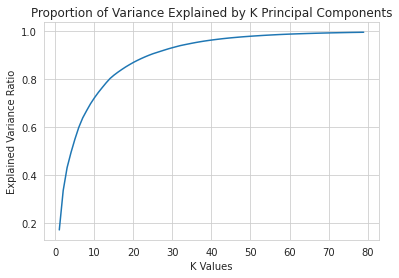

In [ ]:
# Plot explained variance against PCA Component Count
plt.plot(k_values, exp_var)
plt.title("Proportion of Variance Explained by K Principal Components")
plt.xlabel("K Values")
plt.ylabel("Explained Variance Ratio")
plt.show()

### GMM with PCA

When we run a GMM model with 60 principal components, we see the accuracy dip below 50%. This is likely not a good model to use on its own.

In [ ]:
gm_train_data, gm_train_labels = X_train[0:400000], y_train[0:400000]

#Perform a 60 component PCA
pca = PCA(n_components=60)
pca_dat = pca.fit_transform(gm_train_data)
pca_tst = pca.transform(test_data)

#Fit and test a 2 component GMM
gm = GaussianMixture(n_components=2, covariance_type='tied', random_state=12345)
gm.fit(pca_dat,gm_train_labels)
pred = gm.predict(pca_tst)
print(accuracy_score(test_labels,pred))


0.4943


### Two GMM Models

In a final attempt to improve the model with PCA

GMM Loop: 2
GMM Loop: 3
GMM Loop: 4
GMM Loop: 5


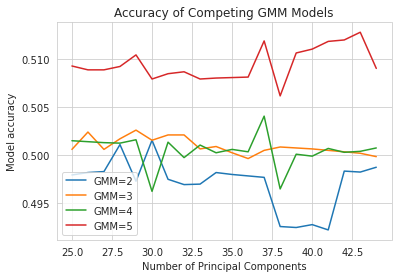

In [ ]:
cov_typ='spherical'



for gmm_n in range(2,6):
    accuracies = []
    for pca_n in range(25,45):
        
        pca = PCA(n_components=pca_n)
        pca_dat = pca.fit_transform(mini_train_data)
        pca_test = pca.transform(test_data)

        #Generate 2 GMM models, one for positive data, one for negative
        gm_pos = GaussianMixture(n_components=gmm_n,covariance_type=cov_typ,random_state=12345)
        gm_neg = GaussianMixture(n_components=gmm_n,covariance_type=cov_typ,random_state=12345)

        #Separate data into positive and negative values
        lab = mini_train_labels.reshape(-1,)
        pos_dat = pca_dat[lab==1]
        neg_dat = pca_dat[lab==0]

        #Fit the two GMM models
        gm_pos.fit(pos_dat)
        gm_neg.fit(neg_dat)

        #Calculate log liklihood using both models
        pos_pred = gm_pos.score_samples(pca_test)
        neg_pred = gm_neg.score_samples(pca_test)

        #Label determination
        pred = (pos_pred > neg_pred) * 1

        #Calculate accuracy
        lab=test_labels.reshape(-1,)
        count_matches = np.sum((pred==lab))
        acc = count_matches/pred.shape[0]
        accuracies.append(acc)

    print("GMM Loop:",gmm_n)
    
    plt.plot(list(range(25,45)),accuracies)
plt.legend(['GMM=2','GMM=3','GMM=4','GMM=5'])
plt.xlabel("Number of Principal Components")
plt.ylabel("Model accuracy")
plt.title("Accuracy of Competing GMM Models")
plt.show()

### Summary

After implementing and refining a Gaussian Mixture Model, we found the results to be generally too inconsistant and unpredictable to have practical value. While this type of model has shown promise in similar applications in the past, its ability to make reliable, accurate predictions based on this dataset is questionable.

## Supervised Autoencoder Multi Layer Perceptron (MLP)

In [151]:
# train autoencoder for classification with no compression in the bottleneck layer
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

Epoch 1/3
1000/1000 - 6s - loss: 0.0023 - accuracy: 0.7811 - val_loss: 6.3569e-04 - val_accuracy: 0.8635
Epoch 2/3
1000/1000 - 4s - loss: 5.7232e-04 - accuracy: 0.8341 - val_loss: 4.8133e-04 - val_accuracy: 0.8482
Epoch 3/3
1000/1000 - 4s - loss: 4.7812e-04 - accuracy: 0.8469 - val_loss: 4.4715e-04 - val_accuracy: 0.8754
Accuracy: [0.86353999376297, 0.8482199907302856, 0.8753799796104431]


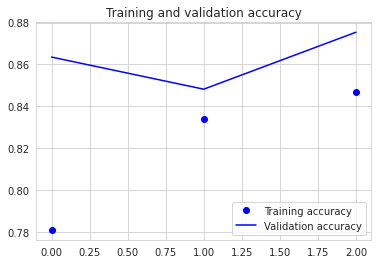

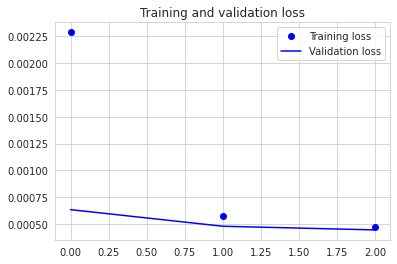

|    | model                                               |   accuracy |     utility |
|---:|:----------------------------------------------------|-----------:|------------:|
|  0 | CNN Model                                           | 470.445    |    0.507735 |
|  1 | Supervised Autoencoder Multi Layer Perceptron (MLP) |   0.88598  | 4455.7      |
|  2 | CNN Model                                           |   0.507735 |  470.445    |
|  3 | Supervised Autoencoder Multi Layer Perceptron (MLP) |   0.87538  | 5378.92     |


In [187]:
# Iniitalize varialbes, define train and test data.
horse_race_mlp = {'model' : [], 'accuracy' : [], 'utility' : []}

X_train_mlp = mini_train_data
y_train_mlp = mini_train_labels
X_test_mlp = dev_data
y_test_mlp = dev_labels

n_inputs = train_data.shape[1]

# Source: https://machinelearningmastery.com/autoencoder-for-classification/
# scale data
t = MinMaxScaler()
t.fit(X_train_mlp)
X_train_mlp = t.transform(X_train_mlp)
X_test_mlp = t.transform(X_test_mlp)
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# output layer
#output = Dense(n_inputs, activation='softmax')(d)
output = Dense(n_inputs, activation='sigmoid')(d)

# define autoencoder model
mlp_model = Model(inputs=visible, outputs=output)

# compile autoencoder model
mlp_model.compile(optimizer='adam', loss='mse', metrics='accuracy')

# fit the autoencoder model to reconstruct input
history_mlp = mlp_model.fit(X_train_mlp, X_train_mlp, epochs=3, batch_size=50, verbose=2, validation_data=(X_test_mlp,X_test_mlp))
#history_mlp = mlp_model.fit(X_train_mlp, y_train_mlp, epochs=3, batch_size=50, verbose=2, validation_data=(X_test_mlp,y_test_mlp))

# Source: https://www.datacamp.com/community/tutorials/autoencoder-classifier-python 
print("Accuracy:", history_mlp.history['val_accuracy'])

# Plot accuracy and loss history over epoch iterations
accuracy = history_mlp.history['accuracy']
val_accuracy = history_mlp.history['val_accuracy']
loss = history_mlp.history['loss']
val_loss = history_mlp.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Source: https://www.datacamp.com/community/tutorials/autoencoder-classifier-python
# Unlike the CNN where we have a built-in predict_classes() function, the autoencoder MLP doesn't have a built in function.
# Therefore, we will create it ourselves with the predict() function.
predicted_classes = (mlp_model.predict(dev_data) > 0.5).astype("int32")
predicted_classes = predicted_classes.argmax(axis=-1)
# print(mlp_model.predict(dev_data)[0])
# print(max(mlp_model.predict(dev_data)[0]))
# print(min(mlp_model.predict(dev_data)[0]))
# print(predicted_classes)

# Append to MLP's own horse race table to sanity check.
# horse_race_mlp['model'].append("Supervised Autoencoder Multi Layer Perceptron (MLP)")
# horse_race_mlp['accuracy'].append(max(history_mlp.history['val_accuracy']))
# #print("Predicted Classes Shape:", predicted_classes.shape)
# #print("Dev_Dates Shape:", dev_dates.shape)
# horse_race_mlp['utility'].append(utility(dev_weights,dev_resps, predicted_classes,dev_dates))
# print(tabulate(pd.DataFrame(horse_race_mlp), tablefmt="pipe", headers="keys"))

# Append to main horse race table. 
horse_race['model'].append("Supervised Autoencoder Multi Layer Perceptron (MLP)")
horse_race['accuracy'].append(max(history_mlp.history['val_accuracy']))
horse_race['utility'].append(utility(dev_weights,dev_resps, predicted_classes,dev_dates))

print(tabulate(pd.DataFrame(horse_race), tablefmt="pipe", headers="keys"))

## Conclusion

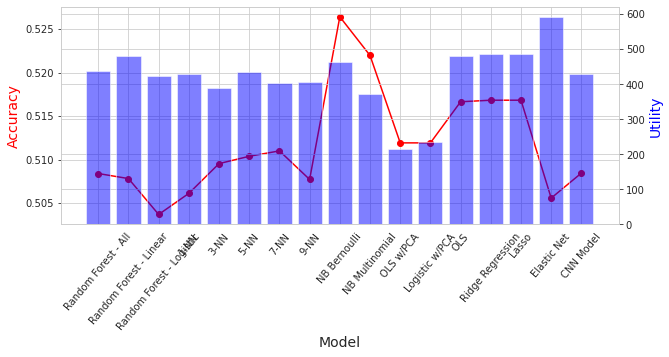

In [73]:
# Plot horse race
# Source: https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python-with-matplotlib/
#print(horse_race)

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(10,4))
# make a plot
ax.plot(horse_race['model'], horse_race['accuracy'], color="red", marker="o")
#ax.bar(horse_race['model'], horse_race['accuracy'], color="red")
# set x-axis label
ax.set_xlabel("Model",fontsize=14)
# set y-axis label
ax.set_ylabel("Accuracy",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
#ax2.plot(horse_race['model'], horse_race['utility'],color="blue",marker="o")
ax2.bar(horse_race['model'], horse_race['utility'],color="blue", alpha = 0.5)
ax2.set_ylabel("Utility",color="blue",fontsize=14)
# Prevent x labels from overlapping
# Source: https://programmersought.com/article/50984561968/
# Source: https://stackoverflow.com/questions/8384120/equivalent-function-for-xticks-for-an-axessubplot-object
ax.set_xticklabels(horse_race['model'], rotation=50, fontsize=10)

plt.show()

# Save the plot as a jpg file
fig.savefig('drive/MyDrive/w207-6-spring2021-fintech/horse_race.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

# Export to csv
df = pd.DataFrame(horse_race) 
df.to_csv('drive/MyDrive/w207-6-spring2021-fintech/Excel Files/horse_race_to_csv.csv')

Text of conclusion

## Areas for Improvement and Future Work

Text of Areas for Improvement and Future Work

## References

1. LSTM:
  * https://colah.github.io/posts/2015-08-Understanding-LSTMs/
  * https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0227222#:~:text=Long%20short%2Dterm%20memory%20(LSTM,helps%20predict%20financial%20time%20series.
  

2. CNN: 
  * https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
  * https://webcache.googleusercontent.com/search?q=cache:O_aNQyJ29XMJ:
  * https://missinglink.ai/guides/convolutional-neural-networks/python-convolutional-neural-network-creating-cnn-keras-tensorflow-plain-python/+&cd=1&hl=en&ct=clnk&gl=us 
  * https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
  * https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f
